Install & Imports

In [8]:
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [9]:
CSV_PATH = "movie_metadata.csv"

df_raw = pd.read_csv(CSV_PATH, low_memory=False)
print(df_raw.shape)
df_raw.head(3)

(5043, 28)


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000


Clean & Normalize Columns


In [10]:
df = df_raw.copy()

# Standardize column names (lowercase + underscore)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Fix known quirks in the sample: trailing spaces / non-breaking spaces in titles
def clean_title(s):
    if pd.isna(s): 
        return s
    s = str(s)
    s = s.replace("\xa0", " ")  # NBSP to regular space
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["movie_title"] = df["movie_title"].apply(clean_title)

# Treat empty strings as NaN
df = df.replace({"": np.nan})

# Numeric coercions (ignore errors -> NaN)
num_cols = [
    "duration","director_facebook_likes","actor_1_facebook_likes",
    "actor_2_facebook_likes","actor_3_facebook_likes",
    "num_critic_for_reviews","num_user_for_reviews","num_voted_users",
    "cast_total_facebook_likes","gross","budget","title_year",
    "imdb_score","aspect_ratio","movie_facebook_likes"
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Quick sanity
df[["movie_title","genres","director_name","actor_1_name","imdb_score"]].head(5)


,movie_title,genres,director_name,actor_1_name,imdb_score
0,Avatar,Action|Adventure|Fantasy|Sci-Fi,James Cameron,CCH Pounder,7.9
1,Pirates of the Caribbean: At World's End,Action|Adventure|Fantasy,Gore Verbinski,Johnny Depp,7.1
2,Spectre,Action|Adventure|Thriller,Sam Mendes,Christoph Waltz,6.8
3,The Dark Knight Rises,Action|Thriller,Christopher Nolan,Tom Hardy,8.5
4,Star Wars: Episode VII - The Force Awakens,Documentary,Doug Walker,Doug Walker,7.1


Build Content Text for Each Movie

In [11]:
def safe_tokens(s, splitter=None):
    if pd.isna(s):
        return []
    s = str(s).lower().strip()
    if splitter:
        toks = [t.strip() for t in s.split(splitter) if t.strip()]
    else:
        toks = [s]
    # replace spaces inside multiword names → single token
    toks = [t.replace(" ", "") for t in toks]
    return toks

def build_content_row(row):
    tokens = []
    tokens += safe_tokens(row.get("genres"), splitter="|")
    tokens += safe_tokens(row.get("plot_keywords"), splitter="|")
    tokens += safe_tokens(row.get("director_name"))
    tokens += safe_tokens(row.get("actor_1_name"))
    tokens += safe_tokens(row.get("actor_2_name"))
    tokens += safe_tokens(row.get("actor_3_name"))
    tokens += safe_tokens(row.get("language"))
    tokens += safe_tokens(row.get("country"))
    tokens += safe_tokens(row.get("content_rating"))
    return " ".join(tokens)

df["content_text"] = df.apply(build_content_row, axis=1).fillna("")
df[["movie_title","content_text"]].head(3)


,movie_title,content_text
0,Avatar,action adventure fantasy sci-fi avatar future ...
1,Pirates of the Caribbean: At World's End,action adventure fantasy goddess marriagecerem...
2,Spectre,action adventure thriller bomb espionage seque...


TF-IDF Vectorization of Content

In [12]:
# Character/word mix is possible, but word uni- and bi-grams are a great start
tfidf = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 2),
    min_df=2,           # ignore ultra-rare tokens (tune if dataset is small)
    stop_words="english"
)

X_text = tfidf.fit_transform(df["content_text"])
X_text


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 92076 stored elements and shape (5043, 10447)>

Add Numeric Features

In [13]:
def log1p_safe(x):
    return np.log1p(np.clip(x, a_min=0, a_max=None))

numeric_features = pd.DataFrame({
    "imdb_score": df["imdb_score"].fillna(df["imdb_score"].median()),
    "year": df["title_year"].fillna(df["title_year"].median()),
    "duration": df["duration"].fillna(df["duration"].median()),
    "log_budget": log1p_safe(df["budget"]),
    "log_gross": log1p_safe(df["gross"]),
    "log_votes": log1p_safe(df["num_voted_users"]),
})

# Scale to [0,1] then L2-normalize later when combining with text
num_scaler = MinMaxScaler()
X_num = num_scaler.fit_transform(numeric_features)

# Convert to sparse to combine efficiently with TF-IDF
X_num_sparse = sparse.csr_matrix(X_num)
X_num_sparse.shape


(5043, 6)

Combine Text + Numeric Features

In [16]:
# weights to balance text vs numeric signals
TEXT_WEIGHT = 0.8
NUM_WEIGHT  = 0.2

# 🧮 fill any NaN before scaling (important!)
numeric_features = numeric_features.fillna(0)

# scale numeric features to [0,1]
num_scaler = MinMaxScaler()
X_num = num_scaler.fit_transform(numeric_features)

# ensure no NaN slipped through (edge safety)
X_num = np.nan_to_num(X_num, nan=0.0)

# convert to sparse
X_num_sparse = sparse.csr_matrix(X_num)

# apply block weights
X_text_scaled = X_text.multiply(TEXT_WEIGHT)
X_num_scaled  = X_num_sparse.multiply(NUM_WEIGHT)

# horizontally stack → final feature matrix
X_all = sparse.hstack([X_text_scaled, X_num_scaled]).tocsr()

# normalize row-wise so cosine similarity works well
X_all = normalize(X_all, norm="l2", axis=1, copy=False)

print("✅ Combined feature matrix built!")
print(f"Shape: {X_all.shape}")

✅ Combined feature matrix built!
Shape: (5043, 10453)


Create Lookup Helpers

In [17]:
# Handle duplicate titles by keeping first occurrence (you can change strategy)
title_to_idx = {}
for i, t in enumerate(df["movie_title"].fillna("")):
    if t and t not in title_to_idx:
        title_to_idx[t.lower()] = i

def find_index_by_title(query_title: str):
    if not query_title:
        return None
    q = query_title.lower().strip()
    # exact first
    if q in title_to_idx:
        return title_to_idx[q]
    # simple fuzzy: best contains match by Jaccard over tokens
    qtok = set(q.split())
    best_i, best_sim = None, 0.0
    for t,i in title_to_idx.items():
        ttok = set(t.split())
        if not qtok or not ttok: 
            continue
        jac = len(qtok & ttok) / len(qtok | ttok)
        if jac > best_sim:
            best_sim, best_i = jac, i
    return best_i


Recommend Function : Compute cosine similarity

In [18]:
def recommend(query_title=None, index=None, k=10, exclude_same_title=True):
    """
    Either provide a movie title or a direct row index to get 'more like this'.
    Returns a DataFrame of top-k recommendations with similarity scores.
    """
    if index is None:
        index = find_index_by_title(query_title)
    if index is None:
        raise ValueError("Movie not found. Try a different title or check spelling.")
    
    # compute similarity to all movies (on the fly; fine for <= ~50k rows)
    v = X_all[index]
    sims = cosine_similarity(v, X_all).ravel()
    
    # build candidates
    candidates = np.argsort(-sims)
    if exclude_same_title:
        candidates = [i for i in candidates if i != index]
    top = candidates[:k]
    
    out = df.iloc[top][[
        "movie_title","genres","director_name","actor_1_name","actor_2_name","actor_3_name",
        "imdb_score","title_year","duration","budget","gross","num_voted_users"
    ]].copy()
    out.insert(1, "similarity", sims[top])
    return out.reset_index(drop=True)

# quick smoke test (change the title to one that exists in your file)
# recommend("Avatar", k=10)


Data Visualization (EDA)

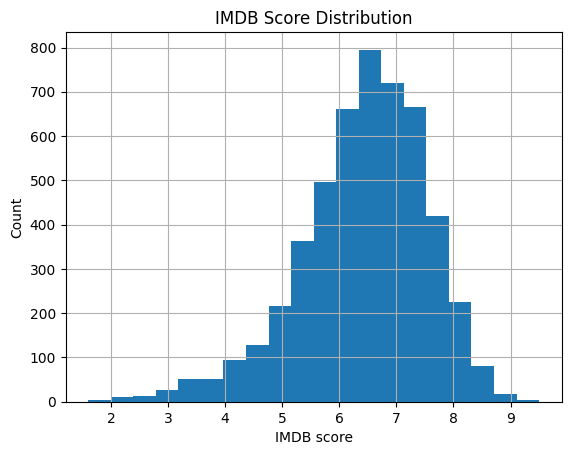

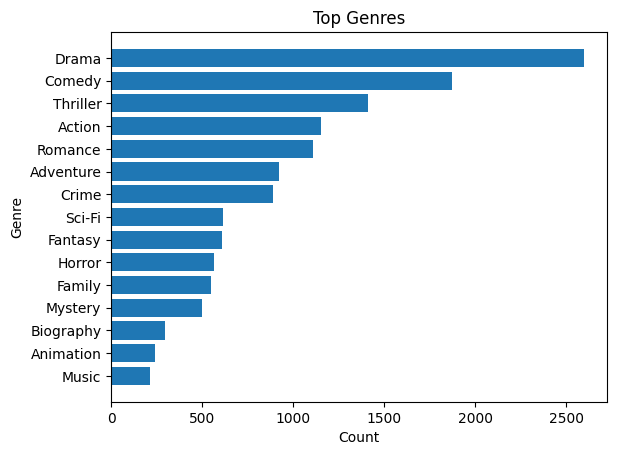

In [19]:
# IMDB score distribution
df["imdb_score"].hist(bins=20)
plt.title("IMDB Score Distribution")
plt.xlabel("IMDB score"); plt.ylabel("Count")
plt.show()

# Top 15 genres
from collections import Counter

def genre_list(s):
    return [g.strip() for g in str(s).split("|") if g and g != "nan"]

all_genres = []
df["genres"].dropna().apply(lambda s: all_genres.extend(genre_list(s)))
counts = Counter(all_genres).most_common(15)

labels = [g for g,_ in counts]
vals   = [n for _,n in counts]

plt.barh(labels, vals)
plt.title("Top Genres")
plt.xlabel("Count"); plt.ylabel("Genre")
plt.gca().invert_yaxis()
plt.show()


Try Out Recommendations

In [20]:
tests = [
    "Avatar",
    "The Dark Knight Rises",
    "Spectre",
    "Pirates of the Caribbean: At World's End",
]

for t in tests:
    try:
        print(f"\n### Recommendations for: {t}")
        display(recommend(t, k=7))
    except Exception as e:
        print(f"⚠️ {t}: {e}")



### Recommendations for: Avatar


,movie_title,similarity,genres,director_name,actor_1_name,actor_2_name,actor_3_name,imdb_score,title_year,duration,budget,gross,num_voted_users
0,Deep Rising,0.404962,Action|Adventure|Horror|Sci-Fi,Stephen Sommers,Djimon Hounsou,Jason Flemyng,Wes Studi,6.0,1998.0,106.0,45000000.0,11146409.0,26551
1,Mystery Men,0.398184,Action|Comedy|Fantasy|Sci-Fi,Kinka Usher,Janeane Garofalo,Wes Studi,Eddie Izzard,6.0,1999.0,121.0,65000000.0,29655590.0,53970
2,Star Wars: Episode V - The Empire Strikes Back,0.396912,Action|Adventure|Fantasy|Sci-Fi,Irvin Kershner,Harrison Ford,Kenny Baker,Anthony Daniels,8.8,1980.0,127.0,18000000.0,290158751.0,837759
3,X-Men Origins: Wolverine,0.385849,Action|Adventure|Fantasy|Sci-Fi|Thriller,Gavin Hood,Hugh Jackman,Ryan Reynolds,Dominic Monaghan,6.7,2009.0,119.0,150000000.0,179883016.0,361924
4,Star Wars: Episode III - Revenge of the Sith,0.377904,Action|Adventure|Fantasy|Sci-Fi,George Lucas,Natalie Portman,Christopher Lee,Hayden Christensen,7.6,2005.0,140.0,113000000.0,380262555.0,520104
5,The Omega Code,0.377696,Action|Adventure|Fantasy|Sci-Fi|Thriller,Robert Marcarelli,George Coe,William Hootkins,Ayla Kell,3.5,1999.0,100.0,7500000.0,12610552.0,4682
6,X-Men: The Last Stand,0.377050,Action|Adventure|Fantasy|Sci-Fi|Thriller,Brett Ratner,Hugh Jackman,Kelsey Grammer,Daniel Cudmore,6.8,2006.0,104.0,210000000.0,234360014.0,383427



### Recommendations for: The Dark Knight Rises


,movie_title,similarity,genres,director_name,actor_1_name,actor_2_name,actor_3_name,imdb_score,title_year,duration,budget,gross,num_voted_users
0,Inception,0.576199,Action|Adventure|Sci-Fi|Thriller,Christopher Nolan,Leonardo DiCaprio,Tom Hardy,Joseph Gordon-Levitt,8.8,2010.0,148.0,160000000.0,292568851.0,1468200
1,Don Jon,0.463139,Comedy|Drama|Romance,Joseph Gordon-Levitt,Joseph Gordon-Levitt,Scarlett Johansson,Tony Danza,6.6,2013.0,90.0,3000000.0,24475193.0,190494
2,G.I. Joe: The Rise of Cobra,0.390616,Action|Adventure|Sci-Fi|Thriller,Stephen Sommers,Joseph Gordon-Levitt,Dennis Quaid,Leo Howard,5.8,2009.0,118.0,175000000.0,150167630.0,174578
3,500 Days of Summer,0.380618,Comedy|Drama|Romance,Marc Webb,Joseph Gordon-Levitt,Chloë Grace Moretz,Zooey Deschanel,7.7,2009.0,95.0,7500000.0,32391374.0,376600
4,10 Things I Hate About You,0.376620,Comedy|Drama|Romance,Gil Junger,Joseph Gordon-Levitt,Heath Ledger,Andrew Keegan,7.2,1999.0,97.0,16000000.0,38176108.0,222099
5,Premium Rush,0.375852,Action|Crime|Thriller,David Koepp,Joseph Gordon-Levitt,Dania Ramirez,Aasif Mandvi,6.5,2012.0,91.0,35000000.0,20275446.0,95274
6,50/50,0.375843,Comedy|Drama|Romance,Jonathan Levine,Joseph Gordon-Levitt,Anna Kendrick,Bryce Dallas Howard,7.7,2011.0,100.0,8000000.0,34963967.0,270441



### Recommendations for: Spectre


,movie_title,similarity,genres,director_name,actor_1_name,actor_2_name,actor_3_name,imdb_score,title_year,duration,budget,gross,num_voted_users
0,Die Hard with a Vengeance,0.427533,Action|Adventure|Thriller,John McTiernan,Bruce Willis,Aldis Hodge,Kevin Chamberlin,7.6,1995.0,128.0,90000000.0,100012500.0,299258
1,Executive Decision,0.420046,Action|Adventure|Thriller,Stuart Baird,Oliver Platt,Joe Morton,J.T. Walsh,6.4,1996.0,133.0,55000000.0,68750000.0,40858
2,3 Days to Kill,0.399654,Action|Drama|Thriller,McG,Connie Nielsen,Richard Sammel,Tómas Lemarquis,6.2,2014.0,123.0,28000000.0,30688364.0,69355
3,Skyfall,0.388634,Action|Adventure|Thriller,Sam Mendes,Albert Finney,Helen McCrory,Rory Kinnear,7.8,2012.0,143.0,200000000.0,304360277.0,522048
4,Skyfall,0.388634,Action|Adventure|Thriller,Sam Mendes,Albert Finney,Helen McCrory,Rory Kinnear,7.8,2012.0,143.0,200000000.0,304360277.0,522030
5,Spy Kids 2: Island of Lost Dreams,0.377554,Action|Adventure|Comedy|Family|Sci-Fi,Robert Rodriguez,Steve Buscemi,Alexa PenaVega,Emily Osment,5.1,2002.0,100.0,38000000.0,85570368.0,44885
6,The World Is Not Enough,0.370890,Action|Adventure|Thriller,Michael Apted,Colin Salmon,Maria Grazia Cucinotta,Desmond Llewelyn,6.4,1999.0,128.0,135000000.0,126930660.0,157519



### Recommendations for: Pirates of the Caribbean: At World's End


,movie_title,similarity,genres,director_name,actor_1_name,actor_2_name,actor_3_name,imdb_score,title_year,duration,budget,gross,num_voted_users
0,Pirates of the Caribbean: The Curse of the Bla...,0.807280,Action|Adventure|Fantasy,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,8.1,2003.0,143.0,140000000.0,305388685.0,809474
1,Pirates of the Caribbean: Dead Man's Chest,0.741793,Action|Adventure|Fantasy,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,7.3,2006.0,151.0,225000000.0,423032628.0,522040
2,The Lone Ranger,0.399460,Action|Adventure|Western,Gore Verbinski,Johnny Depp,Ruth Wilson,Tom Wilkinson,6.5,2013.0,150.0,215000000.0,89289910.0,181792
3,Rango,0.382385,Adventure|Animation|Comedy|Family|Western,Gore Verbinski,Johnny Depp,Ray Winstone,Stephen Root,7.2,2011.0,107.0,135000000.0,123207194.0,183208
4,Pirates of the Caribbean: On Stranger Tides,0.372783,Action|Adventure|Fantasy,Rob Marshall,Johnny Depp,Sam Claflin,Stephen Graham,6.7,2011.0,136.0,250000000.0,241063875.0,370704
5,The Talented Mr. Ripley,0.322084,Crime|Drama|Thriller,Anthony Minghella,Philip Seymour Hoffman,Matt Damon,Jack Davenport,7.3,1999.0,139.0,40000000.0,81292135.0,137891
6,Sinbad: Legend of the Seven Seas,0.305120,Adventure|Animation|Comedy|Drama|Family|Fantas...,Patrick Gilmore,Brad Pitt,Adriano Giannini,Timothy West,6.7,2003.0,85.0,60000000.0,26288320.0,36144


Save Artifacts

In [21]:
import joblib

joblib.dump(tfidf, "tfidf_vectorizer.joblib")
joblib.dump(num_scaler, "numeric_scaler.joblib")
sparse.save_npz("X_all.npz", X_all)

meta = df[["movie_title","imdb_score","genres","director_name","actor_1_name","actor_2_name","actor_3_name","title_year"]].copy()
meta.to_parquet("movies_meta.parquet", index=False)

print("Saved tfidf_vectorizer.joblib, numeric_scaler.joblib, X_all.npz, movies_meta.parquet")


Saved tfidf_vectorizer.joblib, numeric_scaler.joblib, X_all.npz, movies_meta.parquet
